In [1]:
import pandas as pd
import numpy as np


fishing = pd.read_csv("../data/fishing(1).data", header=None, names=('Wind', 'Air', 'Water', 'Sky', 'Fishing'))
fishing_training = fishing.iloc[:14,:]
fishing_testing = fishing.iloc[15:,:]
digits_training = pd.read_csv("../data/digits-train.data", header=None)
digits_testing = pd.read_csv("../data/digits-test.data", header=None)

One-hot encoding vs dummy encoding

In [2]:
dummy_fishing_train =  pd.get_dummies(fishing_training, drop_first=True)
dummy_fishing_test =  pd.get_dummies(fishing_testing, drop_first=True)

In [3]:
train_targets = digits_training.iloc[:,-1]
train_targets_one_hot = pd.get_dummies(train_targets)

In [4]:
from numba import njit, prange

@njit(parallel=True)
def min_max_normalize(narr):
    new_narr = np.full((narr.shape[1], narr.shape[0]), 0.0)

    narr = narr.T

    for i in prange(narr.shape[0]):
        min_val = np.min(narr[i])
        max_val = np.max(narr[i])
        diff = max_val - min_val
        for j in prange(narr.shape[1]):
            if diff == 0:
                new_narr[i,j] = 0
            else:
                new_narr[i,j] = (narr[i,j] - min_val)/diff

    return new_narr.T

In [5]:
# def min_max_normalize(narr):
#     arr_length = len(narr)
#     new_narr = np.empty((0,arr_length))
#
#     for col in narr.T:
#         min_val = np.min(col)
#         max_val = np.max(col)
#         diff = max_val - min_val
#         if diff == 0:
#             new_narr = np.append(new_narr, [np.zeros((arr_length))], axis=0)
#         else:
#             min_max_n_vals = np.divide(np.subtract(col, min_val), diff)
#             new_narr = np.append(new_narr, [min_max_n_vals], axis=0)
#
#     return new_narr

In [6]:
@njit
def get_small_rand(length):
    return np.random.uniform(-0.001, 0.001, size=(length,))

# activation functions

@njit
def get_sum_of_prod(vec, weights):
    vec = np.ascontiguousarray(vec)
    weights = np.ascontiguousarray(weights)
    return np.dot(vec, weights)

@njit
def activation_binary_sigmoid(sigma):
    return 1 / (1 + np.e ** (-sigma))

# @njit
# def activation_softmax(sigmas):
#     return np.exp(sigmas) / np.sum(np.exp(sigmas))

In [7]:
@njit
def feed_forward(vec, weights):
    sop = get_sum_of_prod(vec, weights)
    out = activation_binary_sigmoid(sop)
    return out

In [8]:
@njit
def get_rmse(t_vec, y_vec):
    return np.sqrt(np.sum(np.square(np.subtract(t_vec, y_vec))))/len(t_vec)

@njit
def get_sigmoid_loss(t_vec, y_vec):
    d = np.multiply(y_vec, 1 - y_vec)
    e = t_vec - y_vec
    return np.multiply(d, e)

@njit
def get_hidden_loss(h, w_vec, e_vec):
    h_d = np.multiply(h, 1-h)
    w_e_dot = np.dot(w_vec, e_vec)
    return np.multiply(h_d, w_e_dot)

In [9]:
@njit
def update_weights(error, weights, outs, learning_rate):
    temp = learning_rate * error
    adjustments = np.outer(outs, temp)
    return np.add(weights, adjustments)

    # for i in prange(error.shape[0]):
    #     temp = learning_rate * error[i]
    #     weights_adjustments[i] = np.multiply(outs, temp)
    #
    # return np.add(weights, weights_adjustments.T)

In [10]:
train_input = digits_training.iloc[:,:-1].to_numpy(dtype=float)
train_output = pd.get_dummies(digits_training.iloc[:,-1]).to_numpy(dtype=float)
train_input_normalized = min_max_normalize(train_input)

test_input = digits_testing.iloc[:,:-1].to_numpy(dtype=float)
test_output = pd.get_dummies(digits_testing.iloc[:,-1]).to_numpy(dtype=float)
test_input_normalized = min_max_normalize(test_input)

In [11]:
# arr_t = train_input_normalized.T
#
# arr_t1 = np.array([1.0]*3823)
#
# new_in = np.concatenate(([arr_t1], arr_t)).T
# input_weights = np.reshape(get_small_rand(65 * 50), (65, 50))
#
# hidden_outs = feed_forward(new_in[0], input_weights)
# new_hidden_outs = np.concatenate(([1.0], hidden_outs))
#
# hidden_weights = np.reshape(get_small_rand(51 * 10), (51, 10))
#
# first = feed_forward(new_hidden_outs, hidden_weights)
#
# s_loss = get_sigmoid_loss(train_output[0], first)
#
# test_arr = np.full((10, 51), 0.0)

In [108]:
@njit
def train_neural_net(X, Y, epoch=1, learning_rate=0.5):

    input_n_row = X.shape[0]
    # create array of 1s
    temp_arr = np.array(([1.0] * input_n_row))
    # prepend 1 to each instance
    new_input = np.concatenate((temp_arr.reshape(1,input_n_row), X.T)).T

    # use random number between -.001 and .001 as input weights
    # 65 because 64 inputs and 1 bias
    # 50 because 50 hidden nodes
    input_weights = np.reshape(get_small_rand(65 * 50), (65, 50))
    # input_weights = np.array([1,1,0.5],[1,-1,2])

    # similarly for hidden layer weights
    # 51 because 50 nodes (2/3 of the sum of input and output nodes) and 1 more for bias
    # 10 because 10 output nodes
    hidden_weights = np.reshape(get_small_rand(51 * 10), (51, 10))
    # hidden_weights = np.array([1,1.5,-1])

    rmse = np.zeros((epoch,))

    for i in range(epoch):
        target = np.array([0.])
        y_bar = np.array([0.])
        for row in range(X.shape[0]):

            # outputs at hidden nodes
            hidden_outs = feed_forward(new_input[row], input_weights)
            # prepend 1 as bias
            new_hidden_outs = np.concatenate((np.array([1.0]), hidden_outs))
            # current output
            y_bar = feed_forward(new_hidden_outs, hidden_weights)
            # current target
            target = Y[row]
            # backpropagated output error
            output_error = get_sigmoid_loss(target, y_bar)
            # backpropagated hidden error
            hidden_error = get_hidden_loss(hidden_outs, hidden_weights[1:], output_error)

            new_hidden_weights = update_weights(output_error,hidden_weights, new_hidden_outs, learning_rate)
            hidden_weights = new_hidden_weights

            new_input_weights = update_weights(hidden_error,input_weights, new_input[row], learning_rate)
            input_weights = new_input_weights
        # current rmse
        current_rmse = get_rmse(target, y_bar)
        rmse[i] = current_rmse

    return input_weights, hidden_weights, rmse

In [111]:
test = train_neural_net(train_input_normalized, train_output, epoch=10)

<AxesSubplot:>

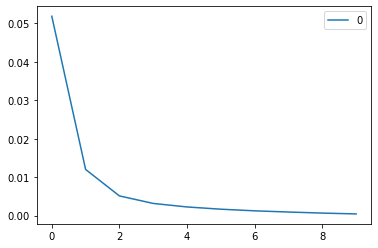

In [112]:
pd.DataFrame(test[2]).plot()

In [43]:
# @njit
def neural_net_predict(input_ws, hidden_ws, X, Y):
    input_n_row = X.shape[0]
    temp_arr = np.array(([1.0] * input_n_row))
    new_X = np.concatenate((temp_arr.reshape(1,input_n_row), X.T)).T
    hidden_outs = feed_forward(new_X, input_ws)
    new_hidden_outs = np.concatenate((np.array([1.0]*input_n_row).reshape(1,input_n_row), hidden_outs.T)).T
    outs = feed_forward(new_hidden_outs, hidden_ws)
    preds = outs.argmax(1)
    return np.sum(preds == Y) / input_n_row

Although optimization is not part of the goal for this assignment, experiment was attempted using the @njit decorator in the Numba package, which translates decorated python code into fast machine code using LLVM.

Results show significant improvement when compared with the version not decorated with @njit. Still, the usual caution applies: vector operations are preferred over loops. Replacing a loop with np.out() in the update_weights() function significantly improved the runtime of the current model.

In the current implementation of training, 20 epochs takes about a bit over 1s to run.

It was mentioned that implementation of neural network may be slow in R.

In [121]:
# %timeit train_neural_net(train_input_normalized, train_output, epoch=100)

6.03 s ± 525 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
weights = train_neural_net(train_input_normalized, train_output, epoch=10)

In [119]:
neural_net_predict(weights[0], weights[1], train_input_normalized, digits_training.iloc[:,-1].to_numpy())

0.9963379544860057

In [120]:
neural_net_predict(weights[0], weights[1], test_input_normalized, digits_testing.iloc[:,-1].to_numpy())


0.9666110183639399